 # Trabajo final
###### Aitor Uranga e Igor Vons
El código está dividido en 3 secciones. Estas a su vez en varias partes.

La [primera sección](#S1) contiene todas las declaraciones de las funciones. Tiene 5 partes:
- En la [1](#S1P1), se declaran las funciones para implementar los métodos de extracción de características expuestos en la primera parte de la guía.
- En la [2](#S1P2), se declaran las que hacen falta para implementar la segunda.
- En la [3](#S1P3) están dos funciones adicionales usadas para poder dividir las imágenes en un mismo número de celdas sin tener que recurrir a deformar las imágenes a un tamaño determinado para poder tener un vector de características de igual longitud para todas la imágenes.
- La [4](#S1P4) ofrece una agrupación de las anteriores, así como las funciones necesarias para tratar, cargar y combinar datasets
- La [5](#S1P5) tiene la declaración de las funciones usadas para generar, almacenar y cargar datasets ya convertidos a vectores de características. Así se consigue realizar pruebas de manera más ágil, porque la extracción de características es un cómputo bastante costoso.

La [segunda sección](#S2) ejecuta el código necesario para estandarizar las imágenes y que encajen para ser divididas en un número fijo de celdas:
- En la [parte 1](#S2P1) se obtienen los tamaños de las celdas en las que se dividirán las imágenes, así como su disposición y se recortan los bordes para dejar solo una imagen del tamaño correcto. Estas imágenes se almacenan en directorios similares a los originales, añadiendo el número de celdas a las que se las ha ajustado al final.
- En la [2](#S2P2), se almacenan las imágenes de entrenamiento y evaluación, así como sus tamaños de celda en un diccionario que se vaya a usar de referencia.
- En la [3](#S2P3), mediante la combinación de distintos parámetros posibles, generamos un conjunto de datos ya vectorizados y los almacenamos en archivos .csv para poder posteriormente cargarlos más rápidamente para realizar pruebas.

La [tercera sección](#S3) es en la que se realiza el entrenamiento y evaluación de diversos modelos que podemos encontrar en la librería de 'sklearn'.
- En la [parte 1](#S3P1) se declaran funciones con las que manejar los clasificadores a probar. Esto es para poder hallar más fácilmente la combinación de parámetros usados en la extracción y los usados para inicializar el clasificador en sí.
- En la [2](#S3P2) ejecutamos un bucle que iterara sobre los parámetros usados en las extracciones de características anteriores. Crea un ranking de modelos en base a la precisión de predicciones en el conjunto de test.
- En la [3](#S3P3) podemos finalmente probar el desempeño del modelo que elijamos a partir de los datos obtenidos en el código anterior sobre el dataset principal de 500 imágenes.

## <a name="S1"></a>Sección 1

In [1]:
import cv2
import numpy as np
from collections import Counter
import os
import imageio.v3 as imageio
import sys
from skimage.color import rgb2gray
import shutil
from tqdm import tqdm
import itertools

#### 1. <a name="S1P1"></a>Extracción de características 1

In [2]:
def uniform_transition_bins():
    """
    Comprueba que secuencias binarias de longitud 8 tienen dos o menos transiciones de 0 a 1 o de 1 a 0.
    :return:
        ndarray sequences: Lista numpy con True para las posiciones que no tengan transiciones de longitud 2 o más y False en caso contrario
    """

    # Inicializar una lista para almacenar las secuencias
    sequences = []
    # Iterar sobre todas las secuencias binarias de 8 bits posibles
    for i in range(2**8):
        # Convertir el entero a una cadena binaria
        sequence = format(i, '08b')

        # Contar el número de transiciones de 0 a 1 o de 1 a 0
        transitions = 0
        for j in range(7):
            if sequence[j] != sequence[j+1]:
                transitions += 1

        # Si hay más de dos transiciones, considerarlo una transición no uniforme
        if transitions > 2:
            sequences.append(False)
        else:
            sequences.append(True)

    sequences = np.array(sequences)
    return sequences

In [3]:
def cell_to_columns(cell, n, m, color=False):
    """
    Convierte una imagen en una matriz de columnas, donde cada una es el binario obtenido de la celda que rodea cada pixel.

    :param ndarray cell: Una imagen.
    :param int n: Tamaño vertical de la celda.
    :param int m: Tamaño horizontal de la celda.
    :param bool color: Indica si la imagen es rgb o escala de grises.

    :return:
        ndarray im2: Una matriz columnas de 8 elementos binarios.
    """

    # Obtener el número de filas y columnas de la imagen
    filas, columnas = cell.shape[0], cell.shape[1]
    a, b = 1, 1

    # Inicializar la matriz de características de celdas binarias
    img2 = np.zeros((n*m, (filas-2)*(columnas-2)))

    # Iterar sobre cada celda de la imagen
    aux = 0
    for i in range(1, filas-1):
        for j in range(1, columnas-1):
            # Obtener el valor binario de la celda
            if color:
                img2[:, aux] = ((cell[i-a:i+a+1, j-b:j+b+1].mean(axis = 2))>(cell[i,j].mean())).flatten()
            else:
                img2[:, aux] = (cell[i - a:i + a + 1, j - b:j + b + 1] > cell[i, j]).flatten()

            # Reordenar los valores binarios para colocarlos en sentido horario
            hardcoded_indx =[1,2,5,8,7,6,3,0,4]
            img2[:, aux] = img2[:, aux][hardcoded_indx]

            aux += 1
    # Eliminamos última fila porque es el elemento central y solo queremos 8 bits
    img2 = img2[:-1,:]

    return img2

In [4]:
def get_cell_histogram(cell, uniform_transitions=None):
    """
    Obtiene las características de una celda en una imagen binaria.

    :param ndarray cell: Una celda de la imagen previeamente transformada por cell_to_columns.
    :param ndarray uniform_transitions: Una lista opcional de booleanos indicando las posiciones del histograma que no comprimir en uno.

    :return: Un vector de características de la celda.
    """

    # Convertir las columnas de 8 elementos binarios (0 o 1) en numeros
    vec = np.packbits(cell, axis = 0)

    # Calcular el histograma de la matriz empaquetada
    h = cv2.calcHist([vec],[0],None,[256],[0,256]).flatten()

    # Si se proporcionan una lista de valores uniformes, insertar el agragado de transiciones no uniformes al principio del histograma
    if uniform_transitions is not None:
        not_uniform = h[(uniform_transitions == False)].sum()
        h = np.insert(h[uniform_transitions], 0, not_uniform)

    return h

In [5]:
def get_image_characteristics_vector_1(img, size, version='v1'):
    """
    Extrae el vector de características de una imagen.

    :param ndarray img: Una imagen en blanco y negro.
    :param int size: El tamaño del lado de las celdas en las que dividir la imagen.
    :param version: v1 es la version de la funcion que no aplica la discriminacion por transiciones uniformes o no en el histograma.
                    v2 si aplica esta diferenciacion.

    :return: Un vector de características de la imagen.
    """

    # Inicializar la matriz de características
    v_caracteristics = np.array([])

    #Determina si la imagen es a color o no
    color = len(img.shape) > 2

    if version == 'v2':
        # Obtener la secuencia de transiciónes uniformes
        uniform_transitions = uniform_transition_bins()

    # Añadir bordes a la imagen
    img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_REPLICATE)

    # Iterar sobre cada celda de la imagen
    for i in range(0, img.shape[0], size):
        for j in range(0, img.shape[1], size):
            # Obtener el vector de características de la celda
            img2 = np.uint8(cell_to_columns(img[i:i + size + 2, j:j + size + 2], 3, 3, color=color))
            if version == 'v2':
                h = (get_cell_histogram(img2, uniform_transitions))
            else:
                h = (get_cell_histogram(img2))

            # Añadir las características de la celda al vector de características de la imagen
            v_caracteristics = np.concatenate((v_caracteristics,h))

    return v_caracteristics

#### <a name="S1P2"></a>2. Extracción de caracteristícas 2

In [6]:
def apply_filter(image, mask):
    """
    Aplica un filtro a la imagen dada utilizando la máscara especificada.

    :param ndarray image: La imagen a la que se aplicará el filtro.
    :param ndarray mask: La máscara que se utilizará para aplicar el filtro.

    :return:
        ndarray img: La imagen filtrada.
    """
    # Hacer una copia de la imagen y convertirla en un array de punto flotante
    img = np.copy(np.float32(image))

    # Obtener el tamaño de la máscara y calcular la distancia del centro al borde
    ni, nj = mask.shape
    mi, mj = ni//2, nj//2

    # Añadir un borde a la imagen utilizando el tamaño de la mitad de la máscara como tamaño del borde
    image_padded = cv2.copyMakeBorder(img, mi, mi, mj, mj, cv2.BORDER_REPLICATE)

    # Recorrer todos los píxeles de la imagen
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Aplicar la convolución al píxel actual multiplicando la máscara
            # con la región correspondiente de la imagen (con el borde añadido)
            # y sumando los valores resultantes
            img[i, j] = (image_padded[i:i+ni, j:j+nj] * mask).sum()

    # Devolver la imagen modificada
    return img

In [7]:
def gradient(img, grad_type='prewitt'):
    """
    Calcula el gradiente de una imagen utilizando los filtros de Prewitt o Sobel.

    :param ndarray img: Imagen de entrada.
    :param str grad_type: Tipo de gradiente a utilizar ('prewitt' o 'sobel').

    :return:
        ndarray e: Magnitud del gradiente.
        ndarray phi: Dirección del gradiente.
    """
    # Convierte la imagen a un array numpy de float32
    im = np.float32(img)

    # Define los filtros de gradiente
    if grad_type=='prewitt':
        # Filtros de gradiente de Prewitt
        m_g_x = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
        m_g_y = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    elif grad_type=='sobel':
        # Filtros de gradiente de Sobel
        m_g_x = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        m_g_y = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    else:
        # Tipo de gradiente desconocido
        sys.exit(f'Unknown gradient type \'{grad_type}\'')

    # Aplica los filtros de gradiente a la imagen
    imx = apply_filter(im, m_g_x)
    imy = apply_filter(im, m_g_y)

    # Calcula la magnitud y dirección del gradiente
    e = np.sqrt(imx**2 + imy**2)
    phi = np.rad2deg(np.arctan2(imy, imx))

    # Devuelve la magnitud y dirección del gradiente
    return e, phi

In [8]:
def discretize_angles(img):
    """
    Discretiza los ángulos en 9 bin.

    :param ndarray img: Imagen de ángulos.

    :return:
        ndarray img : Imagen de ángulos discretizada.
    """
    img[((-20 <= img) & (img < 0)) | ((0 <= img) & (img < 20))] = 1
    img[((-40 <= img) & (img < -20)) | ((20 <= img) & (img < 40))] = 2
    img[((-60 <= img) & (img < -40)) | ((40 <= img) & (img < 60))] = 3
    img[((-80 <= img) & (img < -60)) | ((60 <= img) & (img < 80))] = 4
    img[((-100 <= img) & (img < -80)) | ((80 <= img) & (img < 100))] = 5
    img[((-120 <= img) & (img < -100)) | ((100 <= img) & (img < 120))] = 6
    img[((-140 <= img) & (img < -120)) | ((120 <= img) & (img < 140))] = 7
    img[((-160 <= img) & (img < -140)) | ((140 <= img) & (img < 160))] = 8
    img[((-180 <= img) & (img < -160)) | ((160 <= img) & (img <= 180))] = 9
    return img

In [9]:
def get_image_characteristics_vector_2(img, size, version='v1', M=2, grad_type='prewitt'):
    """
    Calcula un histograma de direcciones de gradiente en una imagen. Solo soprota imagenes en escala de grises

    :param ndarray img: Imagen de entrada.
    :param int size: Tamaño del lado de la celda.
    :param str version: Normalización a aplicar a los histogramas ('v1', 'v2', o 'v3').
    :param int M: Tamaño de bloque de celdas en la normalización 'v2' y 'v3'.
    :param str grad_type: Tipo de gradiente a utilizar ('prewitt' o 'sobel').

    :return:
        ndarray characterictics: El vector de caracteristicas.
    """

    # Calcula la magnitud y dirección del gradiente
    e, phi = gradient(img, grad_type)

    # Discretiza las direcciones del gradiente en 9 bin
    phi = discretize_angles(phi)

    # Inicializa el histograma
    h = np.empty((int(np.ceil(e.shape[0]/size)), int(np.ceil(e.shape[1]/size)), 9))

    # Rellena el histograma con valores de gradiente
    for i in range(0,e.shape[0],size):
        for j in range(0,e.shape[1],size):
            h_p = np.zeros(9)
            for k in range(1,9+1):
                h_p[k-1] = np.sum(e[i:i+size, j:j+size][phi[i:i+size, j:j+size]==k])
            h[i//size, j//size,:] = h_p

    # Elige el tipo de normalización
    # Normaliza solo en función de su propio valor
    if version== 'v1':
        norm_factor = np.linalg.norm(h, axis=2)[:,:,np.newaxis]
        norm_factor[norm_factor==0] = 1 # Evita divisiones entre 0
        h /= norm_factor
        characterictics = h.reshape((h.shape[0]*h.shape[1]*9,))

    # Normaliza por bloques de M celdas
    elif version== 'v2':
        for i in range(0,h.shape[0]):
            for j in range(0,h.shape[1]):
                h_p = h[i:min(i+M,h.shape[0]),j:min(j+M,h.shape[1]),:]
                norm_factor = np.linalg.norm(h_p)
                norm_factor = norm_factor if norm_factor > 0 else 1# Evita divisiones entre 0
                h_p /= norm_factor
                h[i:min(i+M,h.shape[0]),j:min(j+M,h.shape[1]),:] = h_p
        characterictics = h.reshape((h.shape[0]*h.shape[1]*9,))

    # Normaliza cada uno por bloques de M celdas
    elif version== 'v3':
        h_mod = np.empty(0)
        for i in range(0,h.shape[0]-M+1):
            for j in range(0,h.shape[1]-M+1):
                h_p = h[i:min(i+M,h.shape[0]),j:min(j+M,h.shape[1]),:]
                norm_factor = np.linalg.norm(h_p)
                norm_factor = norm_factor if norm_factor > 0 else 1# Evita divisiones entre 0
                h_p /= norm_factor
                h_mod = np.concatenate((h_mod, h_p.flatten()),axis=0)
        characterictics = h_mod

    else:
        sys.exit(f'Unknown normalization type \'{version}\'')

    return characterictics

#### <a name="S1P3"></a>3. Funciones adicionales para estandarizar el número de celdas

In [10]:
def get_size_combinations(S):
    """
    Calcula todas las combinaciones posibles de dos tamaños (nxm) que formen el tamaño total dado.
    También calcula las proporciones de cada uno de estos tamaños.

    :param int S: El número de celdas deseadas.

    :return:
        np.ndarray possible_ns: El array con todos los posibles valores de número de celdas en vertical.
        np.ndarray possible_ns: El array con todos los posibles valores de número de celdas en horizontal.
        np.ndarray proportions: El array con las proporciones entre celdas verticales y horizontales (n:m)
        para el tamaño dado. Sigue el orden de possible_ns.
    """
    possible_ns = []
    # Recorrer todos los números desde 1 hasta la mitad del tamaño total (a pratir de ahi se repite en orden inverso)
    for n in range(1,S//2+1):
        # Si el tamaño total es divisible por n, añadir n a la lista de posibles tamaños
        if S%n==0:
            possible_ns.append(n)
    # Calcular las proporciones de cada tamaño utilizando el tamaño al cuadrado dividido por el tamaño total
    proportions = np.square(np.array(possible_ns))/S
    possible_ns = np.array(possible_ns)
    possible_ms = np.int8(possible_ns/proportions)

    # Devolver una tupla con los tamaños y las proporciones
    return possible_ns, possible_ms, proportions

In [11]:
def get_image_cell_size(img, props, ns, ms):
    """
    Obtiene el tamaño de celda y proporcion de celdas que mejor se ajusten a la imagen dada y al número de celdas en las que
    queremos dividirla.

    :param ndarray img: Imagen de entrada.
    :param ndarray props: Proporciones posibles para el tamaño y el número de celdas.
    :param ndarray ns: Números de celdas en vertical dependiendo de la proporción.
    :param ndarray ms: Números de celdas en horizontal dependiendo de la proporción.

    :return:
        size (int): Tamaño del lado de la celda cuadrada óptima para la imagen.
        correction_info (dict): Un diccionario con la información necesaria para poder tratar la imagen conforme al tamaño
        que se le haya identificado como óptimo.
            d_x y cf_x indican el numero de pixeles a eliminar verticalmente (2*d_x+cf_x)
            d_y y cf_y indican el numero de pixeles a eliminar horizontalmente (2*d_y+cf_y)
            n y m son el numero de celdas en vetical y horizontal en las que se divide la imagen, resectivamente
            p es la proporcion elegida, viene dada por n:m
    """
    p = img.shape[0]/img.shape[1]
    indx = np.argmin(np.abs(props-p))

    size1 = img.shape[0]//ns[indx]
    size2 = img.shape[1]//ms[indx]

    size = min(size1, size2)

    d_x = int(img.shape[0]/2-size*(ns[indx]/2))
    cf_x = 1
    if (img.shape[0]/2-size*(ns[indx]/2)).is_integer():
        cf_x = 0

    d_y = int(img.shape[1]/2-size*(ms[indx]/2))
    cf_y = 1
    if (img.shape[1]/2-size*(ms[indx]/2)).is_integer():
        cf_y = 0

    correction_info = {
        'd_x':d_x,
        'cf_x':cf_x,
        'd_y':d_y,
        'cf_y':cf_y,
        'n':ns[indx],
        'm':ms[indx],
        'p':props[indx]
    }
    return size, correction_info

#### <a name="S1P4"></a>4. Funciones de operación del dataset

In [12]:
def extract_characteristics(dataset, sizes, extraction_model='base', version='v1', M=2, grad_type='prewitt'):
    """
    Tranforma un conjunto de imagenes en un vector de caracteristicas siguiendo el extraction_model.

    :param list dataset: Lista con las imagenes de las que se quiere extraer sus vectores de características.
    :param ndarray sizes: Lista de tamaños de celda para cada imagen del dataset.
    :param str extraction_model: Tipo de extraccion de caracteristicas a aplicar. Puede ser base o grad.
    :param str version: Version del metodo de extraccion.
    :param int M: Para el modelo grad y version 2 o 3 se puede suminsitrar un tamaño de bloque de normalizacion.
    :param str grad_type: Para el modelo grad ('prewitt' o 'sobel').

    :return:
        ndarray X: Matriz de vectores de caracteristicas del dataset de tamaño NxM donde N es el número de ejemplos y el tamaño del vector de caracteristicas.
    """
    X = []
    # Iterar sobre cada imagen en el dataset
    for i in tqdm(range(len(dataset))):
        # Obtener la imagen y el tamaño de la celda
        image = dataset[i]
        size = sizes[i]

        # Extrae el vector de caracteristicas de la imagen
        if extraction_model == 'base':
            v_caracteristics = get_image_characteristics_vector_1(image, size, version=version)
        elif extraction_model == 'grad':
            v_caracteristics = get_image_characteristics_vector_2(image, size, version=version, M=M, grad_type=grad_type)
        else:
            sys.exit(f'Unknown version \'{version}\'')
        X.append(v_caracteristics)

    # TRATAMIENTO DE VECTORES ERRONEOS
    shape_counts = Counter([x.shape for x in X])
    reference_shape = shape_counts.most_common(1)[0][0]

    print(f"tamaño de referencia: {reference_shape}")


    aux_X = []
    for i, vector in enumerate(X[:]):
        if vector.shape == reference_shape:
            aux_X.append(vector)
        else:
            print(f'descarte :{i} con tamaño: {vector.shape}')

    print(f'tamaño de dataset {len(X)} -> {len(aux_X)}')

    # Convertir la lista de vectores de caracteristicas en un array de NumPy
    X = np.array(aux_X)
    return X

In [13]:
def standarize_dataset(input_directory, N, colorized=True, clear_output=False):
    """
    Estandariza un conjunto de imágenes de entrada para que se puedan dividir en un mismo numero de celdas.

    :param str input_directory: Directorio de entrada con las imágenes.
    :param int N: Número de celdas deseado.
    :param bool colorized: Indica si se quiere mantener las imagenes a color.
    :param bool clear_output: Indica si se quiere vaciar el directorio de salida si existe.

    :return:
        output_directory (str): Directorio de salida con las imágenes modificadas y los txt con su informacion
    """
    # Se obtienen las posibles combinaciones nxm tal que el total de celdas sea N
    ns, ms, proportions = get_size_combinations(N)

    # Creacion de un directorio de salida si no existe, si existe error
    output_directory = input_directory+'_crop_size_'+str(N) if colorized else input_directory+'_grayscale_crop_size_'+str(N)

    if os.path.exists(output_directory):
        if clear_output:
            shutil.rmtree(output_directory)
            os.makedirs(output_directory)
        else:
            sys.exit(f'Directory already exists \'{output_directory}\'')
    else:
        os.makedirs(output_directory)


    # Itera sobre los archivos en el directorio
    for filename in tqdm(os.listdir(input_directory)):
        # Comprueba si se trata de JPG
        if not filename.endswith(".jpg"):
            continue

        # Lectura y tratamiento de la imagen
        image = imageio.imread(os.path.join(input_directory, filename))
        if not colorized:
            image = rgb2gray(image)
            image = (image*255).astype(np.uint8)

        # Recorte de la imagen al tamaño determinado por el tamaño de celda elegido
        # Se elimina de ambos lados para que la imagen quede centrada
        size, c_info=get_image_cell_size(image, proportions, ns, ms)
        image = image[c_info['d_x']:image.shape[0]-c_info['d_x']-c_info['cf_x'],
                      c_info['d_y']:image.shape[1]-c_info['d_y']-c_info['cf_y']]

        # Guardado de la imagen tratada en el nuevo directorio
        imageio.imwrite(os.path.join(output_directory, filename), image)

        # Creacion de archivo txt con los datos de la imagen
        base_name = os.path.splitext(filename)[0]
        with open(os.path.join(output_directory, base_name + ".txt"), "w") as f:
            f.write(f"image={filename}\nN={N}\np={c_info['p']}\nn={c_info['n']}\nm={c_info['m']}\nsize={size}\n")

    return output_directory

In [14]:
def load_dataset(input_directory):
    """
    Carga un conjunto de imagenes localizado en input_directory y sus tamaños almacenados en el fichero asociado.

    :param str input_directory: Directorio de entrada con las imágenes.

    :return:
        list data: Vector que contiene las imagenes cargadas del directorio.
        ndarray sizes: Lista de tamaños de celda calculados para cada imagen del dataset, en el mismo orden.
    """
    data = []
    sizes = []

    # Iterar sobre los archivos en el directorio de entrada
    for filename in tqdm(os.listdir(input_directory)):
        # Verificar si el archivo es JPG
        if not filename.endswith(".jpg"):
            continue
        # Lectura de la imagen
        image = imageio.imread(os.path.join(input_directory, filename))

        # Abrir el archivo txt con la informacion en modo lectura
        base_name = os.path.splitext(filename)[0]
        with open(os.path.join(input_directory, base_name + ".txt"), "r") as f:
            # Leer todas las líneas del archivo en una lista
            lines = f.readlines()

        # Iterar sobre las líneas del archivo en orden inverso
        for line in reversed(lines):
            # Verificar si la línea comienza con "size="
            if line.startswith("size="):
                # Extraer el valor después de "size=" y asignarlo a la variable size
                size = int(line.split("=")[1])
                break

        data.append(image)
        sizes.append(size)

    data = data
    sizes = np.array(sizes)

    return data, sizes

In [15]:
def load_combine_datasets(n=100, n_cells=84):
    """
    Carga y combina los datos de entrenamiento y prueba para perros y gatos.

    :param int n: Número de imágenes a cargar.
    :param int n_cells: Número de celdas a utilizar para el tamaño de recorte de las imágenes.

    :return:
        dict data: Diccionario con los datos de entrenamiento y prueba para perros y gatos en escala de grises y a color.
    """

    print(f'Loading datasets({n})')

    data1_dog_train, sizes1_dog_train = load_dataset(f'cat_dog_{n}/train/dog_crop_size_{n_cells}')
    data1_cat_train, sizes1_cat_train = load_dataset(f'cat_dog_{n}/train/cat_crop_size_{n_cells}')
    data1_dog_test, size1_dog_test = load_dataset(f'cat_dog_{n}/test/dog_crop_size_{n_cells}')
    data1_cat_test, size1_cat_test = load_dataset(f'cat_dog_{n}/test/cat_crop_size_{n_cells}')

    data2_dog_train, sizes2_dog_train = load_dataset(f'cat_dog_{n}/train/dog_grayscale_crop_size_{n_cells}')
    data2_cat_train, sizes2_cat_train = load_dataset(f'cat_dog_{n}/train/cat_grayscale_crop_size_{n_cells}')
    data2_dog_test, size2_dog_test = load_dataset(f'cat_dog_{n}/test/dog_grayscale_crop_size_{n_cells}')
    data2_cat_test, size2_cat_test = load_dataset(f'cat_dog_{n}/test/cat_grayscale_crop_size_{n_cells}')

    data = {
        'color':{
            'train':{
                'cat':{
                    'data':data1_cat_train,
                    'sizes':sizes1_cat_train
                    },
                'dog':{
                    'data':data1_dog_train,
                    'sizes':sizes1_dog_train
                    }
                },
            'test':{
                'cat':{
                    'data':data1_cat_test,
                    'sizes':size1_cat_test
                    },
                'dog':{
                    'data':data1_dog_test,
                    'sizes':size1_dog_test
                    }
                }
            },
        'grayscale':{
            'train':{
                'cat':{
                    'data':data2_cat_train,
                    'sizes':sizes2_cat_train
                    },
                'dog':{
                    'data':data2_dog_train,
                    'sizes':sizes2_dog_train
                    }
                },
            'test':{
                'cat':{
                    'data':data2_cat_test,
                    'sizes':size2_cat_test
                    },
                'dog':{
                    'data':data2_dog_test,
                    'sizes':size2_dog_test
                    }
                }
            }
    }

    return data

In [16]:
def extract_combine_datasets(data, colorized=True, extraction_model='base', version='v1', M=2, grad_type='prewitt'):
    """
    Combina los datos de entrenamiento y prueba para perros y gatos.

    :param dict data: Diccionario con los datos de entrenamiento y prueba para perros y gatos en escala de grises o a color.
    :param bool colorized: Booleano que indica si se deben extraer las características de los datos a color o en escala de grises.
    :param str extraction_model: Modelo de extracción a utilizar para la extracción de características.
    :param str version: Versión del modelo de extracción a utilizar.
    :param int M: Para el modelo grad y version 2 o 3 se puede suminsitrar un tamaño de bloque de normalizacion.
    :param str grad_type: Para el modelo grad ('prewitt' o 'sobel').

    :return:
        ndarray X, y, Xtest, ytest: Cuatro arrays NumPy con los datos de entrenamiento y prueba para perros y gatos.
    """

    if colorized:
        if extraction_model=='grad':
            sys.exit(f'Incompatible extraction model \'{extraction_model}\' for colorized images')

        print('Extracting characteristics (colored)')
        X_dog_train = extract_characteristics(data['color']['train']['dog']['data'], data['color']['train']['dog']['sizes'],
                                              extraction_model=extraction_model, version=version, M=M, grad_type=grad_type)
        y_dog_train = np.zeros(np.array(X_dog_train).shape[0])

        X_cat_train = extract_characteristics(data['color']['train']['cat']['data'], data['color']['train']['cat']['sizes'],
                                              extraction_model=extraction_model, version=version, M=M, grad_type=grad_type)
        y_cat_train = np.ones(np.array(X_cat_train).shape[0])

        X_dog_test = extract_characteristics(data['color']['test']['dog']['data'], data['color']['test']['dog']['sizes'],
                                             extraction_model=extraction_model, version=version, M=M, grad_type=grad_type)
        y_dog_test = np.zeros(np.array(X_dog_test).shape[0])

        X_cat_test = extract_characteristics(data['color']['test']['cat']['data'], data['color']['test']['cat']['sizes'],
                                             extraction_model=extraction_model, version=version, M=M, grad_type=grad_type)
        y_cat_test = np.ones(np.array(X_cat_test).shape[0])

    elif not colorized:
        print('Extracting characteristics (grayscale)')

        X_cat_train = extract_characteristics(data['grayscale']['train']['cat']['data'], data['grayscale']['train']['cat']['sizes'],
                                              extraction_model=extraction_model, version=version, M=M, grad_type=grad_type)
        y_cat_train = np.ones(np.array(X_cat_train).shape[0])

        X_dog_train = extract_characteristics(data['grayscale']['train']['dog']['data'], data['grayscale']['train']['dog']['sizes'],
                                              extraction_model=extraction_model, version=version, M=M, grad_type=grad_type)
        y_dog_train = np.zeros(np.array(X_dog_train).shape[0])



        X_dog_test = extract_characteristics(data['grayscale']['test']['dog']['data'], data['grayscale']['test']['dog']['sizes'],
                                             extraction_model=extraction_model, version=version, M=M, grad_type=grad_type)
        y_dog_test = np.zeros(np.array(X_dog_test).shape[0])

        X_cat_test = extract_characteristics(data['grayscale']['test']['cat']['data'], data['grayscale']['test']['cat']['sizes'],
                                             extraction_model=extraction_model, version=version, M=M, grad_type=grad_type)
        y_cat_test = np.ones(np.array(X_cat_test).shape[0])

    X = np.vstack((X_dog_train, X_cat_train))
    y = np.hstack((y_dog_train, y_cat_train)).T

    Xtest = np.vstack((X_dog_test, X_cat_test))
    ytest = np.hstack((y_dog_test, y_cat_test)).T

    # Alterar orden
    perm = np.random.permutation(X.shape[0])
    X = X[perm]
    y = y[perm]

    perm = np.random.permutation(Xtest.shape[0])
    Xtest = Xtest[perm]
    ytest = ytest[perm]

    return X, y, Xtest, ytest

#### <a name="S1P5"></a>5. Funciones de almacenamiento y carga de vectores de características de los datasets

In [17]:
def save_extracted_characteristics(X, y, Xtrain, ytrain, folder_name, override = True):
    """
    Guarda los datos de ejemplos y etiquetas en archivos CSV en la carpeta especificada.

    :param ndarray X: Array NumPy con los datos de ejemplos.
    :param ndarray y: Array NumPy con las etiquetas de los ejemplos.
    :param ndarray Xtrain: Array NumPy con los datos de ejemplos de entrenamiento.
    :param ndarray ytrain: Array NumPy con las etiquetas de entrenamiento de los ejemplos.
    :param str folder_name: Nombre de la carpeta donde se deben guardar los archivos.
    :param bool override: Booleano que indica si se deben sobrescribir los archivos si ya existen.
    """
    if os.path.exists(folder_name):
        if override:
            shutil.rmtree(folder_name)
            os.makedirs(folder_name)
        else:
            sys.exit(f'Directory already exists \'{folder_name}\'')
    else:
        os.makedirs(folder_name)

    # Guardar datos en csv
    np.savetxt(os.path.join(folder_name, 'X.csv'), X, delimiter=',')
    np.savetxt(os.path.join(folder_name, 'y.csv'), y, delimiter=',')
    np.savetxt(os.path.join(folder_name, 'Xtrain.csv'), Xtrain, delimiter=',')
    np.savetxt(os.path.join(folder_name, 'ytrain.csv'), ytrain, delimiter=',')

In [18]:
def load_extracted_characteristics(folder_name):
    """
    Carga los datos de ejemplos y etiquetas de archivos CSV de la carpeta especificada.

    :param str folder_name: Nombre de la carpeta donde se encuentran los archivos.
    :return:
        ndarray X, y, Xtrain, ytrain: Cuatro arrays NumPy con los datos de ejemplos y etiquetas cargados.
    """
    X = np.loadtxt(f'{folder_name}/X.csv', delimiter=',')
    y = np.loadtxt(f'{folder_name}/y.csv', delimiter=',')
    Xtrain = np.loadtxt(f'{folder_name}/Xtrain.csv', delimiter=',')
    ytrain = np.loadtxt(f'{folder_name}/ytrain.csv', delimiter=',')

    return X, y, Xtrain, ytrain

## <a name="S2"></a>Seccion 2

#### <a name="S2P1"></a>1. Tratado previo de imagenes

In [179]:
n_cells = 84 # Número de celdas en las que se desea dividir las imágenes
n = 100 # dataset

In [180]:
directories=[f"cat_dog_{n}/test/cat",
           f"cat_dog_{n}/test/dog",
           f"cat_dog_{n}/train/cat",
           f"cat_dog_{n}/train/dog"]

for directory in directories:
    standarize_dataset(directory, n_cells, colorized=True, clear_output=True)
    standarize_dataset(directory, n_cells, colorized=False, clear_output=True)

100%|██████████| 500/500 [00:05<00:00, 87.19it/s]


#### <a name="S2P2"></a>2. Cargado de los datasets

In [181]:
data = load_combine_datasets(n=n)

Loading datasets(500)


100%|██████████| 200/200 [00:00<00:00, 214.10it/s]


#### <a name="S2P3"></a>3. Extraccion de carateristicas y almacenamiento de datos

In [ ]:
# Posibles valores a combinar
colorized_values = [True, False]
extraction_model_values = ['base', 'grad']
version_values = ['v1', 'v2', 'v3']
M_values = [2, 4, 6]
grad_type_values = ['prewitt', 'sobel']

input_combinations = itertools.product(colorized_values, extraction_model_values, version_values, M_values, grad_type_values)

# Iteramos sobres las posibles combinaciones
for inputs in tqdm(input_combinations, position=1, leave=False):
    colorized, extraction_model, version, M, grad_type = inputs

    # Omintimos combinaciones no compatibles
    if colorized and extraction_model == 'grad':
        continue
    if extraction_model == 'base' and version == 'v3':
        continue
    if extraction_model == 'grad' and version != 'v2' and version != 'v3' and M != 2:
        continue
    if extraction_model == 'base' and (M != 2 or grad_type != 'prewitt'):
        continue

    # Extraemos los vectores de caracteristicas de los datasets
    color = 'color' if colorized else 'grayscale'

    # El nombre del directorio contiene el valor de los parametros de la iteración en la que se ha ejecutado.
    # Aunque algunos de ellos puedan llegar a no usarse en el proceso de extraccion, semantienen en el nombre para mantener un estandar.
    print(f'Treating data:{color}_{extraction_model}_{version}_{M}_{grad_type}')
    X, y, Xtest, ytest = extract_combine_datasets(data, colorized, extraction_model, version, M, grad_type)
    save_extracted_characteristics(X, y, Xtest, ytest, f'{n_cells}/{color}_{extraction_model}_{version}_{M}_{grad_type}')


## <a name="S3"></a>Sección 3

#### <a name="S3P1"></a>1. Declaracion de funciones para manejo de clasificadores

In [19]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import time

In [20]:
def LogisticRegression_test(X, y, Xtest, ytest):
    """
    Carga los datos de ejemplos y etiquetas y realiza una prueba de regresión logística utilizando validación cruzada y búsqueda de rejilla.

    :param ndarray X: Array NumPy con los datos de ejemplos para entrenamiento.
    :param ndarray y: Array NumPy con las etiquetas de los ejemplos de entrenamiento.
    :param ndarray Xtest: Array NumPy con los datos de ejemplos para pruebas.
    :param ndarray ytest: Array NumPy con las etiquetas de los ejemplos de pruebas.
    :return:
    tuple best_params, accTrain, accTest: Tupla con el mejor conjunto de parámetros encontrado, el porcentaje de acierto en el conjunto de entrenamiento y el porcentaje de acierto en el conjunto de pruebas, respectivamente.
    """
    # Se incializa el modelo llamando al constructor de la regresión lineal: todos los parámetros se asignan a los valores mencionados anteriormente
    LogReg = LogisticRegression()

    # Set up cross-validation with ShuffleSplit and grid search with GridSearchCV
    rs = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    param_grid = {'C': [1], 'max_iter': [200, 300, 400], 'solver': ['newton-cg', 'lbfgs']}#NOTA: 'liblinear', 'sag' (best of 10) eliminados C100 eliminado (best of 10) C10 eliminado(best of 7)
    clf = GridSearchCV(LogReg, param_grid, n_jobs=-1, cv=rs)

    # Fit the model to the data
    clf.fit(X, y)

    # Get the best estimator
    best_estimator = clf.best_estimator_

    # Cálculo del porcentaje de acierto (recuerda no pasar la columna de 1's)
    pred_train = best_estimator.predict(X)
    pred_test = best_estimator.predict(Xtest)
    accTrain = metrics.accuracy_score(pred_train, y)
    accTest = metrics.accuracy_score(pred_test, ytest)

    best_params = clf.best_params_

    return best_params, accTrain, accTest

In [21]:
def MultinomialNB_test(X, y, Xtest, ytest):
    """
    Carga los datos de ejemplos y etiquetas y realiza una prueba de clasificacion por naive bayes utilizando validación cruzada y búsqueda de rejilla.

    :param ndarray X: Array NumPy con los datos de ejemplos para entrenamiento.
    :param ndarray y: Array NumPy con las etiquetas de los ejemplos de entrenamiento.
    :param ndarray Xtest: Array NumPy con los datos de ejemplos para pruebas.
    :param ndarray ytest: Array NumPy con las etiquetas de los ejemplos de pruebas.
    :return:
    tuple best_params, accTrain, accTest: Tupla con el mejor conjunto de parámetros encontrado, el porcentaje de acierto en el conjunto de entrenamiento y el porcentaje de acierto en el conjunto de pruebas, respectivamente.
    """
    # Configurar validación cruzada con ShuffleSplit y búsqueda con GridSearchCV
    rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    param_grid = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}
    clf = GridSearchCV(MultinomialNB(), param_grid, cv=rs)

    # Ajustar el modelo a los datos
    clf.fit(X, y)

    # Obtener el mejor estimador
    best_estimator = clf.best_estimator_

    # Obtener predicciones
    pred_train = best_estimator.predict(X)
    pred_test = best_estimator.predict(Xtest)

    # Calcular precisión
    accTrain = metrics.accuracy_score(pred_train, y)
    accTest = metrics.accuracy_score(pred_test, ytest)
    best_params = clf.best_params_
    return best_params, accTrain, accTest

In [22]:
def MLPClassifier_test(X, y, Xtest, ytest):
    """
    Carga los datos de ejemplos y etiquetas y realiza una prueba de clasificador mlp utilizando validación cruzada y búsqueda de rejilla.

    :param ndarray X: Array NumPy con los datos de ejemplos para entrenamiento.
    :param ndarray y: Array NumPy con las etiquetas de los ejemplos de entrenamiento.
    :param ndarray Xtest: Array NumPy con los datos de ejemplos para pruebas.
    :param ndarray ytest: Array NumPy con las etiquetas de los ejemplos de pruebas.
    :return:
    tuple best_params, accTrain, accTest: Tupla con el mejor conjunto de parámetros encontrado, el porcentaje de acierto en el conjunto de entrenamiento y el porcentaje de acierto en el conjunto de pruebas, respectivamente.
    """
    # Configurar validación cruzada con ShuffleSplit y búsqueda de grilla con GridSearchCV
    rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    param_grid = {'hidden_layer_sizes': [10, 15, 20], 'max_iter': [200, 250, 300], 'solver': ['lbfgs']}
    clf = GridSearchCV(MLPClassifier(), param_grid, cv=rs)

    # Ajustar el modelo a los datos
    clf.fit(X, y)

    # Obtener el mejor estimador
    best_estimator = clf.best_estimator_

    # Obtener predicciones
    pred_train = best_estimator.predict(X)
    pred_test = best_estimator.predict(Xtest)

    # Calcular precisión
    accTrain = metrics.accuracy_score(pred_train, y)
    accTest = metrics.accuracy_score(pred_test, ytest)
    best_params = clf.best_params_

    return  best_params, accTrain, accTest

In [23]:
def SVC_test(X, y, Xtest, ytest):
    """
    Carga los datos de ejemplos y etiquetas y realiza una prueba de clasificador svc utilizando validación cruzada y búsqueda de rejilla.

    :param ndarray X: Array NumPy con los datos de ejemplos para entrenamiento.
    :param ndarray y: Array NumPy con las etiquetas de los ejemplos de entrenamiento.
    :param ndarray Xtest: Array NumPy con los datos de ejemplos para pruebas.
    :param ndarray ytest: Array NumPy con las etiquetas de los ejemplos de pruebas.
    :return:
    tuple best_params, accTrain, accTest: Tupla con el mejor conjunto de parámetros encontrado, el porcentaje de acierto en el conjunto de entrenamiento y el porcentaje de acierto en el conjunto de pruebas, respectivamente.
    """
    # Configurar validación cruzada con ShuffleSplit y búsqueda de grilla con GridSearchCV
    rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    param_grid = {'C': [0.01, 0.03, 0.1, 0.3, 1, 3], 'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3]}
    clf = GridSearchCV(svm.SVC(), param_grid, n_jobs=-1, cv=rs)

    # Ajustar el modelo a los datos
    clf.fit(X, y)

    # Obtener el mejor estimador
    best_estimator = clf.best_estimator_

    # Obtener predicciones
    pred_train = best_estimator.predict(X)
    pred_test = best_estimator.predict(Xtest)

    # Calcular la precisión
    accTrain = metrics.accuracy_score(pred_train, y)
    accTest = metrics.accuracy_score(pred_test, ytest)

    best_params = clf.best_params_

    return best_params, accTrain, accTest

In [24]:
def RandomForest_test(X, y, Xtest, ytest):
    """
    Carga los datos de ejemplos y etiquetas y realiza una prueba de clasificador encemble de random forest utilizando validación cruzada y búsqueda de rejilla.

    :param ndarray X: Array NumPy con los datos de ejemplos para entrenamiento.
    :param ndarray y: Array NumPy con las etiquetas de los ejemplos de entrenamiento.
    :param ndarray Xtest: Array NumPy con los datos de ejemplos para pruebas.
    :param ndarray ytest: Array NumPy con las etiquetas de los ejemplos de pruebas.
    :return:
    tuple best_params, accTrain, accTest: Tupla con el mejor conjunto de parámetros encontrado, el porcentaje de acierto en el conjunto de entrenamiento y el porcentaje de acierto en el conjunto de pruebas, respectivamente.
    """
    # Set up cross-validation with ShuffleSplit and grid search with GridSearchCV
    rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    param_grid = {'n_estimators': [10, 50, 100, 200],
                  'max_depth': [5, 10, 15],
                  'max_features': ['log2', 'sqrt'],
                  'criterion': ['entropy', 'gini']}
    clf = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, cv=rs)

    # Fit the model to the data
    clf.fit(X, y)

    # Get the best estimator
    best_estimator = clf.best_estimator_

    # Obtain predictions
    pred_train = best_estimator.predict(X)
    pred_test = best_estimator.predict(Xtest)

    # Calculate accuracy
    accTrain = metrics.accuracy_score(pred_train, y)
    accTest = metrics.accuracy_score(pred_test, ytest)

    best_params = clf.best_params_

    return best_params, accTrain, accTest

#### <a name="S3P2"></a>2. Prueba de parametros

In [25]:
from itertools import product

n_cells = 84 # Número de celdas en las que se desea dividir las imágenes
n = 100 # dataset

# Posibles valores a combinar
colorized_values = [True, False]
extraction_model_values = ['base', 'grad']
version_values = ['v1', 'v2', 'v3']
M_values = [2, 4, 6]
grad_type_values = ['prewitt', 'sobel']

# Generamos las posibles combinaciones de parametros
param_combinations = list(product(colorized_values, extraction_model_values, version_values, M_values, grad_type_values))

#Filtramos casos
filtered_param_combinations=[]
for colorized, extraction_model, version, M, grad_type in param_combinations:
    # Omitimos combinaciones no compatibles
    if colorized and extraction_model == 'grad':
        continue
    if extraction_model == 'base' and version == 'v3':
        continue
    if extraction_model == 'grad' and version != 'v2' and version != 'v3' and M != 2:
        continue
    if extraction_model == 'base' and (M != 2 or grad_type != 'prewitt'):
        continue
    filtered_param_combinations.append((colorized, extraction_model, version, M, grad_type))

results = {}

# Iteramos sobre las combinaciones
for colorized, extraction_model, version, M, grad_type in tqdm(filtered_param_combinations,leave=True):

    color = 'color' if colorized else 'grayscale'

    # Cargamos los datos para esta combinacion en particular
    X, y, Xtest, ytest = load_extracted_characteristics(f'{n_cells}/{color}_{extraction_model}_{version}_{M}_{grad_type}')


    params, accTrain, accTest = LogisticRegression_test(X, y, Xtest, ytest)

    results[(color, extraction_model, version, M, grad_type, 'LogisticRegression')] = (params, accTrain, accTest)


    params, accTrain, accTest = MultinomialNB_test(X, y, Xtest, ytest)

    results[(color, extraction_model, version, M, grad_type, 'MultinomialNB')] = (params, accTrain, accTest)


    params, accTrain, accTest = MLPClassifier_test(X, y, Xtest, ytest)

    results[(color, extraction_model, version, M, grad_type, 'MLPClassifier')] = (params, accTrain, accTest)


    params, accTrain, accTest = SVC_test(X, y, Xtest, ytest)

    results[(color, extraction_model, version, M, grad_type, 'SVC')] = (params, accTrain, accTest)


    params, accTrain, accTest = RandomForest_test(X, y, Xtest, ytest)

    results[(color, extraction_model, version, M, grad_type, 'RandomForest')] = (params, accTrain, accTest)




  0%|          | 0/18 [00:00<?, ?it/s]C:\Users\ivons\miniconda3\envs\py38ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 44%|████▍     | 8/18 [13:30<07:47, 46.79s/it]   C:\Users\ivons\miniconda3\envs\py38ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 56%|█████▌    | 10/18 [14:09<04:18, 32.28s/it]C:\Users\ivons\miniconda3\env

In [79]:
best_params = max(results, key=lambda x: results[x][-1])
best_accuracy = results[best_params]
print(f"Best combination of parameters: {best_params}")
print(f"Best test accuracy: {best_accuracy[-1]}")

top_n = 20
sorted_results = sorted(results.items(), key=lambda x: x[1][-1], reverse=True)[:top_n]

for i, (params, (model_params, train_acc, test_acc)) in enumerate(sorted_results):
    print(f"{i+1}. Combination of parameters: {params}: {model_params}, trainAcc:{train_acc}, testAcc:{test_acc}")

Best combination of parameters: ('color', 'base', 'v1', 2, 'prewitt', 'SVC')
Best test accuracy: 1.0
1. Combination of parameters: ('color', 'base', 'v1', 2, 'prewitt', 'SVC'): {'C': 0.01, 'gamma': 0.01}, trainAcc:1.0, testAcc:1.0
2. Combination of parameters: ('color', 'base', 'v2', 2, 'prewitt', 'SVC'): {'C': 0.01, 'gamma': 0.01}, trainAcc:1.0, testAcc:1.0
3. Combination of parameters: ('grayscale', 'base', 'v1', 2, 'prewitt', 'SVC'): {'C': 0.01, 'gamma': 0.01}, trainAcc:1.0, testAcc:1.0
4. Combination of parameters: ('grayscale', 'base', 'v2', 2, 'prewitt', 'SVC'): {'C': 0.01, 'gamma': 0.01}, trainAcc:1.0, testAcc:1.0
5. Combination of parameters: ('grayscale', 'grad', 'v3', 6, 'prewitt', 'SVC'): {'C': 3, 'gamma': 1}, trainAcc:1.0, testAcc:0.95
6. Combination of parameters: ('grayscale', 'grad', 'v3', 2, 'sobel', 'RandomForest'): {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}, trainAcc:0.995, testAcc:0.925
7. Combination of parameters: ('color'

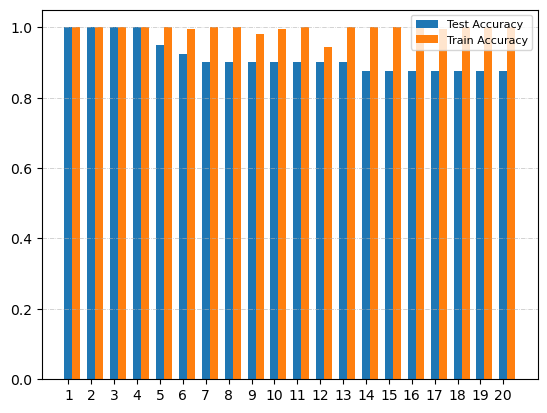

1 ('color', 'base', 'v1', 2, 'prewitt', 'SVC'):{'C': 0.01, 'gamma': 0.01}
2 ('color', 'base', 'v2', 2, 'prewitt', 'SVC'):{'C': 0.01, 'gamma': 0.01}
3 ('grayscale', 'base', 'v1', 2, 'prewitt', 'SVC'):{'C': 0.01, 'gamma': 0.01}
4 ('grayscale', 'base', 'v2', 2, 'prewitt', 'SVC'):{'C': 0.01, 'gamma': 0.01}
5 ('grayscale', 'grad', 'v3', 6, 'prewitt', 'SVC'):{'C': 3, 'gamma': 1}
6 ('grayscale', 'grad', 'v3', 2, 'sobel', 'RandomForest'):{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
7 ('color', 'base', 'v2', 2, 'prewitt', 'LogisticRegression'):{'C': 1, 'max_iter': 200, 'solver': 'newton-cg'}
8 ('grayscale', 'base', 'v1', 2, 'prewitt', 'MLPClassifier'):{'hidden_layer_sizes': 15, 'max_iter': 200, 'solver': 'lbfgs'}
9 ('grayscale', 'grad', 'v2', 2, 'sobel', 'RandomForest'):{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
10 ('grayscale', 'grad', 'v2', 4, 'sobel', 'SVC'):{'C': 1, 'gamma': 3}
11 ('grayscale', 'grad', 'v3',

In [77]:
import matplotlib.pyplot as plt

# Sort the dictionary by test accuracy
sorted_dict = dict(sorted(results.items(), key=lambda x: x[1][2], reverse=True))

# Get the top n entries
n = 20
top_n = dict(list(sorted_dict.items())[:n])

# Extract the numeric values from the keys
x_values = list(range(1,n+1))

# Plot the results
fig, ax = plt.subplots()

bar_width = 0.35
ax.bar(x_values, [x[2] for x in top_n.values()], width=bar_width, label='Test Accuracy')
ax.bar([x+bar_width for x in x_values], [x[1] for x in top_n.values()], width=bar_width, label='Train Accuracy')
ax.legend(fontsize=8)

# Add the grid
ax.grid(linestyle='-.', which='major', axis='y', alpha=0.8, linewidth=0.5)
ax.grid(which='minor', linestyle='-.', alpha=0.8)

# Add the parameters as text labels
names=[]
for i, key in enumerate(top_n.keys()):
    names.append(f'{key}:{top_n[key][0]}')

ax.set_xticks(x_values)

plt.show()
for i, word in enumerate(names):
    print(i+1, word)

#### <a name="S3P3"></a>3. Prueba final

In [81]:
n_cells = 84
n = 500
configuracion = 4 # Elegimos una de las configuraciones observadas en la lista anterior 'sorted_results'

(params, (model_params, train_acc, test_acc)) = sorted_results[configuracion]

colorized = True if params[0]=='color' else False
extraction_model = params[1]
version = params[2]
M = params[3]
grad_type = params[4]

print(f'Extraccion con:{params[:-1]}')

X, y, Xtest, ytest = extract_combine_datasets(load_combine_datasets(n=n, n_cells=n_cells), colorized=colorized,
                                              extraction_model=extraction_model, version=version, M=M, grad_type=grad_type)

classiffier = params[5]

if classiffier == 'LogisticRegression':
    print(f'Clasificacion con LogisticRegression con parametros: {model_params}')
    LogReg = LogisticRegression(C=model_params['C'], max_iter=model_params['max_iter'], solver=model_params['solver'])
    LogReg.fit(X, y)
    pred_train = LogReg.predict(X)
    pred_test = LogReg.predict(Xtest)
    accTrain = metrics.accuracy_score(pred_train, y)
    accTest = metrics.accuracy_score(pred_test, ytest)

    print(f'Precisión en Train: {accTrain}')
    print(f'Precisión en Test: {accTest}')


elif classiffier == 'MultinomialNB':
    print(f'Clasificacion con MultinomialNB con parametros: {model_params}')
    MultiNB = MultinomialNB(alpha=model_params['alpha'])
    MultiNB.fit(X, y)
    pred_train = MultiNB.predict(X)
    pred_test = MultiNB.predict(Xtest)
    accTrain = metrics.accuracy_score(pred_train, y)
    accTest = metrics.accuracy_score(pred_test, ytest)

    print(f'Precisión en Train: {accTrain}')
    print(f'Precisión en Test: {accTest}')

elif classiffier == 'MLPClassifier':
    print(f'Clasificacion con MLPClassifier con parametros: {model_params}')
    MLPClass = MLPClassifier(hidden_layer_sizes=model_params['hidden_layer_sizes'], max_iter=model_params['max_iter'], solver=model_params['solver'])
    MLPClass.fit(X, y)
    pred_train = MLPClass.predict(X)
    pred_test = MLPClass.predict(Xtest)
    accTrain = metrics.accuracy_score(pred_train, y)
    accTest = metrics.accuracy_score(pred_test, ytest)

    print(f'Precisión en Train: {accTrain}')
    print(f'Precisión en Test: {accTest}')

elif classiffier == 'SVC':
    print(f'Clasificacion con SVC con parametros: {model_params}')
    SVC = svm.SVC(C=model_params['C'], gamma=model_params['gamma'])
    SVC.fit(X, y)
    pred_train = SVC.predict(X)
    pred_test = SVC.predict(Xtest)
    accTrain = metrics.accuracy_score(pred_train, y)
    accTest = metrics.accuracy_score(pred_test, ytest)

    print(f'Precisión en Train: {accTrain}')
    print(f'Precisión en Test: {accTest}')

elif classiffier == 'RandomForestClassifier':
    print(f'Clasificacion con RandomForestClassifier con parametros: {model_params}')
    RaFoCla = RandomForestClassifier(n_estimators=model_params['n_estimators'], max_depth=model_params['max_depth'],
                                     max_features=model_params['max_features'],criterion=model_params['criterion'])
    RaFoCla.fit(X, y)
    pred_train = RaFoCla.predict(X)
    pred_test = RaFoCla.predict(Xtest)
    accTrain = metrics.accuracy_score(pred_train, y)
    accTest = metrics.accuracy_score(pred_test, ytest)

    print(f'Precisión en Train: {accTrain}')
    print(f'Precisión en Test: {accTest}')

Extraccion con:('grayscale', 'grad', 'v3', 6, 'prewitt')
Loading datasets(500)


100%|██████████| 200/200 [00:00<00:00, 410.10it/s]


Extracting characteristics (grayscale)


100%|██████████| 500/500 [08:12<00:00,  1.02it/s]


tamaño de referencia: (4536,)
descarte :61 con tamaño: (2916,)
descarte :99 con tamaño: (2916,)
descarte :205 con tamaño: (2916,)
descarte :218 con tamaño: (2916,)
descarte :229 con tamaño: (2916,)
descarte :362 con tamaño: (2916,)
descarte :426 con tamaño: (2916,)
tamaño de dataset 500 -> 493


100%|██████████| 500/500 [08:55<00:00,  1.07s/it]


tamaño de referencia: (4536,)
descarte :199 con tamaño: (2916,)
descarte :249 con tamaño: (2916,)
descarte :292 con tamaño: (2916,)
descarte :313 con tamaño: (2916,)
tamaño de dataset 500 -> 496


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]


tamaño de referencia: (4536,)
tamaño de dataset 100 -> 100


100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


tamaño de referencia: (4536,)
tamaño de dataset 100 -> 100
Clasificacion con SVC con parametros: {'C': 3, 'gamma': 1}
Precisión en Train: 1.0
Precisión en Test: 0.94
